# Bias decomposition with respect to CRE

We decompose the CRE biases into different components.

( This is a partial copy of `${LHOME}/proj/2017-07_icon-nawdex/nbooks/28-repeating_bias_decomposition_with_CRE-bias.ipynb` )

### Background 

CRE is calculated from flux differences (allsky - clearsky) weighted by cloud fraction

$$
CRE = - \sum_{k=0}^K  \overline{ f_k\; (F_k - F_\mathrm{clear}) }
$$

The bias in CRE now comes from cloud fraction and flux biases:

$$
\delta CRE = - \sum_{k=0}^K 
[
\overline{\delta f_k\; (F_k - F_\mathrm{clear})}
+ 
\overline{ f_k\; \delta(F_k - F_\mathrm{clear})} 
]
$$

In [59]:
%matplotlib inline

import os, sys, copy, glob
import numpy as np
import datetime
import pylab as pl
import xarray as xr
import pandas as pd
import string

import seaborn as sns

In [60]:
import nawdex_analysis.io.collector
from nawdex_analysis.plot.legend import plegend, legend_renamer
from nawdex_analysis.config import nawdex_dir

from  nawdex_analysis.plot.stacked_analysis_plots import hor_barplot_exp_plot
import nawdex_analysis.analysis.ave_cre
from nawdex_analysis.plot.stacked_analysis_plots import vert_stacked_exp_plot, get_exp_kws, get_plotting_order

In [61]:
pl.rcParams['figure.figsize'] = (16.0, 8.0)
pl.rcParams['font.size'] = 18.0
pl.rcParams['lines.linewidth'] = 3


## Read Data

In [62]:
fdir = '%s/statistics' % nawdex_dir
fname = '%s/cre_decomposition_allsets_obs-as-ref.nc' % fdir
# fname = '%s/cre_decomposition_allsets.nc' % fdir


dset = xr.open_dataset( fname )

## Average Biases 

In [63]:
aveset = dset.sum('ct').mean('time')
aveset

<xarray.Dataset>
Dimensions:    (component: 5, idname: 16)
Coordinates:
  * idname     (idname) |S17 '10km_oneMom_Conv' ... 'msevi-scaled'
  * component  (component) |S19 'ave_bias' 'cloud_fraction_term' ... 'cre_bias'
Data variables:
    net        (component, idname) float64 2.399 1.603 2.834 ... 4.932 6.596 0.0
    longwave   (component, idname) float64 -4.757 -5.71 -4.762 ... 1.993 0.0
    shortwave  (component, idname) float64 7.157 7.313 7.595 ... 13.67 4.603 0.0

In [64]:
aveset.to_dataframe()

net  longwave  shortwave
component           idname                                          
ave_bias            10km_oneMom_Conv   2.399251 -4.757260   7.156511
                    10km_twoMom_Conv   1.602947 -5.709606   7.312553
                    20km_oneMom_Conv   2.833773 -4.761672   7.595445
                    20km_twoMom_Conv   2.155621 -5.996147   8.151768
                    2km_oneMom_noConv -9.746609 -3.124126  -6.622483
                    2km_oneMom_shConv  0.314155 -5.270284   5.584438
                    2km_twoMom_noConv -7.597120  2.107916  -9.705036
                    2km_twoMom_shConv  1.405054  0.241308   1.163746
                    40km_oneMom_Conv   4.183440 -5.284355   9.467795
                    40km_twoMom_Conv   3.689714 -7.070929  10.760643
                    5km_oneMom_Conv    2.478275 -4.718339   7.196615
                    5km_twoMom_Conv    1.484532 -5.129626   6.614158
                    80km_oneMom_Conv   4.851719 -6.930375  11.782094
                    80km_twoMom_Conv   4.931724 -8.738875  13.670599
                    msevi-not_scaled   6.595704  1.992900   4.602803
                    msevi-scaled       0.000000  0.000000   0.000000
cloud_fraction_term 10km_oneMom_Conv   2.048238  2.642127  -0.593889
                    10km_twoMom_Conv   2.532844  0.777928   1.754916
                    20km_oneMom_Conv   2.262612  2.638347  -0.375735
                    20km_twoMom_Conv   2.680927  0.730979   1.949948
                    2km_oneMom_noConv -0.890093  3.163012  -4.053104
                    2km_oneMom_shConv  1.661332  1.197143   0.464189
                    2km_twoMom_noConv -0.018372  5.659695  -5.678067
                    2km_twoMom_shConv  2.174295  3.941660  -1.767365
                    40km_oneMom_Conv   2.397424  2.412389  -0.014965
                    40km_twoMom_Conv   3.148381  0.258131   2.890250
                    5km_oneMom_Conv    1.803346  3.062059  -1.258713
                    5km_twoMom_Conv    2.162162  1.494263   0.667899
                    80km_oneMom_Conv   3.025070  0.882872   2.142198
                    80km_twoMom_Conv   3.845873 -1.168121   5.013994
...                                         ...       ...        ...
cross_term          20km_oneMom_Conv  -0.852644 -0.527365  -0.325279
                    20km_twoMom_Conv  -1.200110 -0.675178  -0.524932
                    2km_oneMom_noConv -1.157179 -0.661066  -0.496113
                    2km_oneMom_shConv  1.135010 -0.384669   1.519680
                    2km_twoMom_noConv -0.990424 -0.454742  -0.535682
                    2km_twoMom_shConv  1.207589 -0.318665   1.526254
                    40km_oneMom_Conv  -0.866610 -0.558508  -0.308102
                    40km_twoMom_Conv  -0.955297 -0.720630  -0.234667
                    5km_oneMom_Conv   -0.606889 -0.696052   0.089163
                    5km_twoMom_Conv   -0.883684 -0.665548  -0.218136
                    80km_oneMom_Conv  -1.072060 -0.270984  -0.801076
                    80km_twoMom_Conv  -1.153955 -0.461467  -0.692488
                    msevi-not_scaled   0.000000  0.000000   0.000000
                    msevi-scaled       0.000000  0.000000   0.000000
cre_bias            10km_oneMom_Conv   2.399251 -4.757260   7.156511
                    10km_twoMom_Conv   1.602947 -5.709606   7.312553
                    20km_oneMom_Conv   2.833773 -4.761672   7.595445
                    20km_twoMom_Conv   2.155621 -5.996147   8.151768
                    2km_oneMom_noConv -9.746609 -3.124126  -6.622483
                    2km_oneMom_shConv  0.314155 -5.270284   5.584438
                    2km_twoMom_noConv -7.597120  2.107916  -9.705036
                    2km_twoMom_shConv  1.405054  0.241308   1.163746
                    40km_oneMom_Conv   4.183440 -5.284355   9.467795
                    40km_twoMom_Conv   3.689714 -7.070929  10.760643
                    5km_oneMom_Conv    2.478275 -4.718339   7.196615
                    5km_twoMom_Conv    1.4

## Reshape Bias Data

In [65]:
dlist = []
vlist = ['net', 'shortwave', 'longwave']

for vname in vlist:
    d = aveset[vname].expand_dims('var')
    d['var'] = [ vname, ]
    
    dlist += [ d.copy(), ]
dvar = xr.concat( dlist, dim = 'var')
#.rename({'net' : 'biases'})

In [66]:
dcomb = xr.Dataset()
dcomb['abs_bias'] = dvar
dcomb.sel(var = 'net')

<xarray.Dataset>
Dimensions:    (component: 5, idname: 16)
Coordinates:
  * idname     (idname) |S17 '10km_oneMom_Conv' ... 'msevi-scaled'
  * component  (component) |S19 'ave_bias' 'cloud_fraction_term' ... 'cre_bias'
    var        |S3 'net'
Data variables:
    abs_bias   (component, idname) float64 2.399 1.603 2.834 ... 4.932 6.596 0.0

In [67]:
dcomb.component.data

array(['ave_bias', 'cloud_fraction_term', 'radflux_term', 'cross_term',
       'cre_bias'], dtype='|S19')

In [68]:
vlist = ['net', 'shortwave', 'longwave']
complist = ['cre_bias', 'cloud_fraction_term', 'radflux_term', 'cross_term' ]
idlist = list ( dcomb.idname.data )
idlist.remove('msevi-scaled')
idlist.remove('msevi-not_scaled')


## Plotting bias with barplots

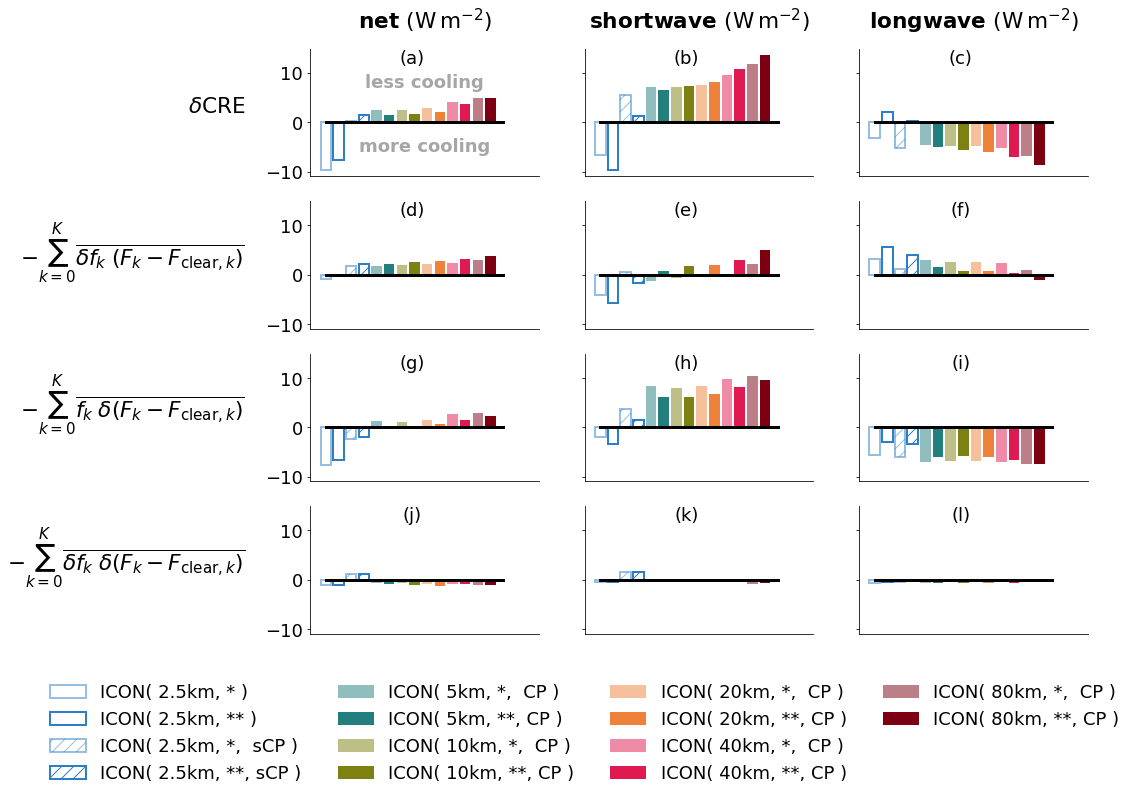

In [69]:
fig, ax = pl.subplots( nrows = 4, ncols = 3, figsize = (18,14), sharex = True, sharey = True )
pl.subplots_adjust( left = 0.3, bottom = 0.3)

abc = string.ascii_lowercase

n = 0
for i, compname in enumerate( complist ):
    for j, vname in enumerate( vlist ):
        pl.sca( ax[i,j] )
        hor_barplot_exp_plot( dcomb.sel(var = vname), 'abs_bias', catlist = [compname, ], 
                      icount0 = 0,  idlist = idlist, 
                      iddim='idname', catdim = 'component', 
                      obsref_name='msevi-scaled', doffset=0.05, offset0=-0.4, make_labels=True)
        
        xlim = pl.xlim()
        
        pl.text( (xlim[1] + xlim[0]) / 2., 13, '(%s)' % abc[n], va = 'center', ha = 'center')
        pl.xticks([])
        
        n += 1
        
    

for j, vname in enumerate( vlist ):
    pl.sca( ax[0, j])
    pl.title('%s $(\mathrm{W\,m^{-2}})$' % vname, fontweight = 'bold', pad = 20)

ylabs = ['$\delta \mathrm{CRE}$',
    '$- \sum_{k=0}^K \overline{\delta f_k\; (F_k - F_{\mathrm{clear},k} )}$',
    '$- \sum_{k=0}^K \overline{f_k\; \delta (F_k - F_{\mathrm{clear},k})}$',
    '$- \sum_{k=0}^K \overline{\delta f_k\; \delta (F_k - F_{\mathrm{clear},k})}$',
         ]
    
for i, compname in enumerate( complist ):
    a = ax[i, 0]
    pl.sca( a )
    
    apos = a.get_position()
    pl.figtext(apos.x0 - 0.05, apos.y0 + apos.height / 2., ylabs[i],
                ha = 'right', fontsize = 'large')

pl.sca( ax[0, 0] )
fdict = dict( fontweight = 'bold', color = 'gray', ha = 'center', alpha = 0.7)
pl.text( (xlim[1] + xlim[0]) / 2. + 0.05, 7, 'less cooling', **fdict )
pl.text( (xlim[1] + xlim[0]) / 2. + 0.05, -6, 'more cooling', **fdict )
    
pl.sca( ax[3, 1] )
pl.bar([0], [0], color='w', alpha=0, label=' ', zorder = 10)
nawdex_analysis.plot.legend.plegend(loc = 'lower center', ncol = 4, bbox_to_anchor = (0., -1.3), fontsize = 'medium' )
sns.despine()
pl.savefig('../pics/cre-bias-decomposition.png', pdi = 300)

# Plotting different biases as function of CT

## Data Preparations

In [70]:

cset = dset.sel(ct = 'very low') + dset.sel(ct = 'fractional')
cset = cset.expand_dims('ct')
cset['ct'] = ['very low / fractional']

cset = xr.concat( [cset, dset], dim = 'ct' )


In [71]:
ctlist = set( cset.ct.data ) - set(['very low', 'fractional', 'semi. above'])
cset =  cset.sel(ct = list( ctlist ))

In [72]:
cset

<xarray.Dataset>
Dimensions:    (component: 5, ct: 9, idname: 16, time: 264)
Coordinates:
  * time       (time) datetime64[ns] 2016-09-21 ... 2016-10-05T23:00:00
  * idname     (idname) |S17 '10km_oneMom_Conv' ... 'msevi-scaled'
  * component  (component) |S19 'ave_bias' 'cloud_fraction_term' ... 'cre_bias'
  * ct         (ct) object 'very high opaque' ... 'high opaque'
Data variables:
    net        (ct, component, time, idname) float64 0.1603 -0.238 ... 0.0
    longwave   (ct, component, time, idname) float64 0.1603 -0.238 ... 0.0
    shortwave  (ct, component, time, idname) float64 -0.0 0.0 -0.0 ... 0.0 0.0

### Rename CT names

In [73]:
ctnames =  cset.ct.data 
ctnames

array(['very high opaque', 'semi. meanly thick', 'clear_ocean', 'middle',
       'semi. thin', 'low', 'very low / fractional', 'semi. thick',
       'high opaque'], dtype=object)

In [74]:
ctnames[1] = 'semi. moderately thick'
ctnames[3] = 'mid-level'

In [75]:
cset.ct

<xarray.DataArray 'ct' (ct: 9)>
array(['very high opaque', 'semi. moderately thick', 'clear_ocean',
       'mid-level', 'semi. thin', 'low', 'very low / fractional',
       'semi. thick', 'high opaque'], dtype=object)
Coordinates:
  * ct       (ct) object 'very high opaque' ... 'high opaque'

### Calculate Mean and STD

In [76]:
catlist = [ 'very low / fractional', 'low', 'mid-level',  
       'high opaque', 'very high opaque', 'semi. thin', 'semi. moderately thick', 'semi. thick',]

idlist = list( cset.idname.data )
idlist.remove( 'msevi-not_scaled' )
idlist.remove( 'msevi-scaled' )


dset = cset.sel(ct = catlist, idname = idlist)
daily_mean = dset.groupby('time.day').mean('time')
# dvar = daily_mean.quantile([0.25, 0.5, 0.75], dim = 'day').diff('quantile')
std_var = daily_mean.std('day')
mean_var = dset.mean('time')

In [77]:
std_var = ( daily_mean.quantile(0.84, 'day') - daily_mean.quantile(0.16, 'day')  ) /2.

### Standard Error of Mean

In [78]:
nday = daily_mean.dims['day']
var_sem = ( daily_mean.quantile(0.84, 'day') - daily_mean.quantile(0.16, 'day')  ) / np.sqrt( nday )

## Plotting

In [79]:
pl.rcParams['font.size'] = 22.0
pl.rcParams['xtick.labelsize'] = 22.0

In [80]:
def plegend():
    handles, labels = pl.gca().get_legend_handles_labels()

    # put msevi on top
    order = range(len(labels))
    mindex = labels.index( 'msevi-scaled')
    order.remove(mindex)
    order = [mindex,] + order

    pl.legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
          loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 'small' )

In [81]:
mean_var

<xarray.Dataset>
Dimensions:    (component: 5, ct: 8, idname: 14)
Coordinates:
  * idname     (idname) |S17 '10km_oneMom_Conv' ... '80km_twoMom_Conv'
  * component  (component) |S19 'ave_bias' 'cloud_fraction_term' ... 'cre_bias'
  * ct         (ct) object 'very low / fractional' 'low' ... 'semi. thick'
Data variables:
    net        (ct, component, idname) float64 2.112 2.467 ... -0.2053 -0.4644
    longwave   (ct, component, idname) float64 -1.043 -0.9779 ... -0.6921 -1.267
    shortwave  (ct, component, idname) float64 3.155 3.445 ... 0.4868 0.803

### Plot Function

In [176]:
pl.rcParams['font.size'] = 28
pl.rcParams['xtick.labelsize'] = 28
pl.rcParams['ytick.labelsize'] = 30



In [177]:
p = pl.rcParams
for k in p.keys():
    if 'label' in k:
        print k, p[k]

axes.labelcolor k
axes.labelpad 4.0
axes.labelsize medium
axes.labelweight normal
legend.labelspacing 0.5
xtick.labelbottom True
xtick.labelsize 28.0
xtick.labeltop False
ytick.labelleft True
ytick.labelright False
ytick.labelsize 30.0


In [193]:
import string

def cre_bias_plot(mean_var, str_var, bias_name, title_name, do_legend = True, fac = 0.37, iletter = 0):
    
    abc = string.lowercase[iletter:]
    
    mbias = mean_var.sel( component = bias_name)
    dbias = std_var.sel( component = bias_name)

    fig, ax = pl.subplots( ncols = 3,  figsize = (fac* 38, fac * 46), )



    pl.sca(ax[0])
    vert_stacked_exp_plot( mbias, 'shortwave' , 
                           var_err = dbias, doffset = 0.06, 
                           connect2obs = False, obsref_name = '2km_oneMom_noConv')
    sns.despine(ax = ax[0])
    # ax[0].yaxis.set_tick_params(labelsize = 24)
    pl.title('(%s)\nShort-\nwave' % abc[0], pad = 20)

    pl.sca(ax[1])
    vert_stacked_exp_plot( mbias, 'longwave' , 
                           var_err = dbias, doffset = 0.06, 
                           connect2obs = False, obsref_name = '2km_oneMom_noConv')
    pl.yticks([])
    pl.title('(%s)\nLong-\nwave' % abc[1], pad = 20)

    pl.sca(ax[2])
    vert_stacked_exp_plot( mbias, 'net' , 
                           var_err = dbias, doffset = 0.06, 
                           connect2obs = False, obsref_name = '2km_oneMom_noConv')
    pl.yticks([])
    pl.title('(%s)\nNet\n' % abc[2], pad = 20)

    
    pl.suptitle(title_name, fontsize = 'x-large', fontweight = 'bold')
    for a in ax:
        a.set_xlim(-6,6)

    for a in ax[:-1]:
        a.axvline(0, color = 'gray', lw = 5, alpha = 0.3)

    a.set_xlabel('CRE bias ($\mathrm{W\, m^{-2}}$)', labelpad = 20)

    for a in ax[1:]:
        sns.despine(left = True, ax = a)

    if do_legend:
        nawdex_analysis.plot.legend.plegend( fontsize = 20,  bbox_to_anchor = (5, 0.5) )

    pl.axvline(0, color = 'gray', lw = 5, alpha = 0.3)
    pl.subplots_adjust( left = 0.3, right = 0.65, top = 0.83 )

    return ax

In [194]:
mean_var.ct.data = ['very low /\nfractional', 'low', 'mid-level', 'high opaque',
       'very high\nopaque', 'semi. thin', 'semi.\nmoderately thick',
       'semi. thick']
std_var.ct.data = mean_var.ct.data
var_sem.ct.data = mean_var.ct.data


### CRE Bias Plot

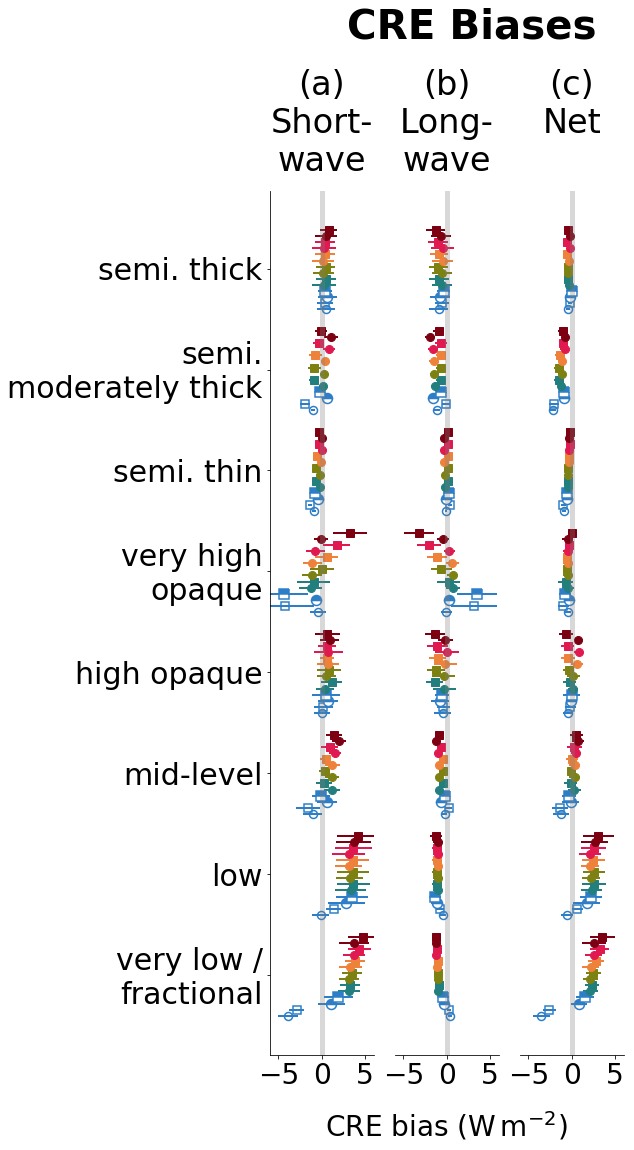

In [196]:
cre_bias_plot( mean_var, var_sem, 'cre_bias', 'CRE Biases', do_legend = False)
pl.savefig( '../pics/cre_bias-vs-ct.png', dpi = 300,)

### Cloud Fraction Term

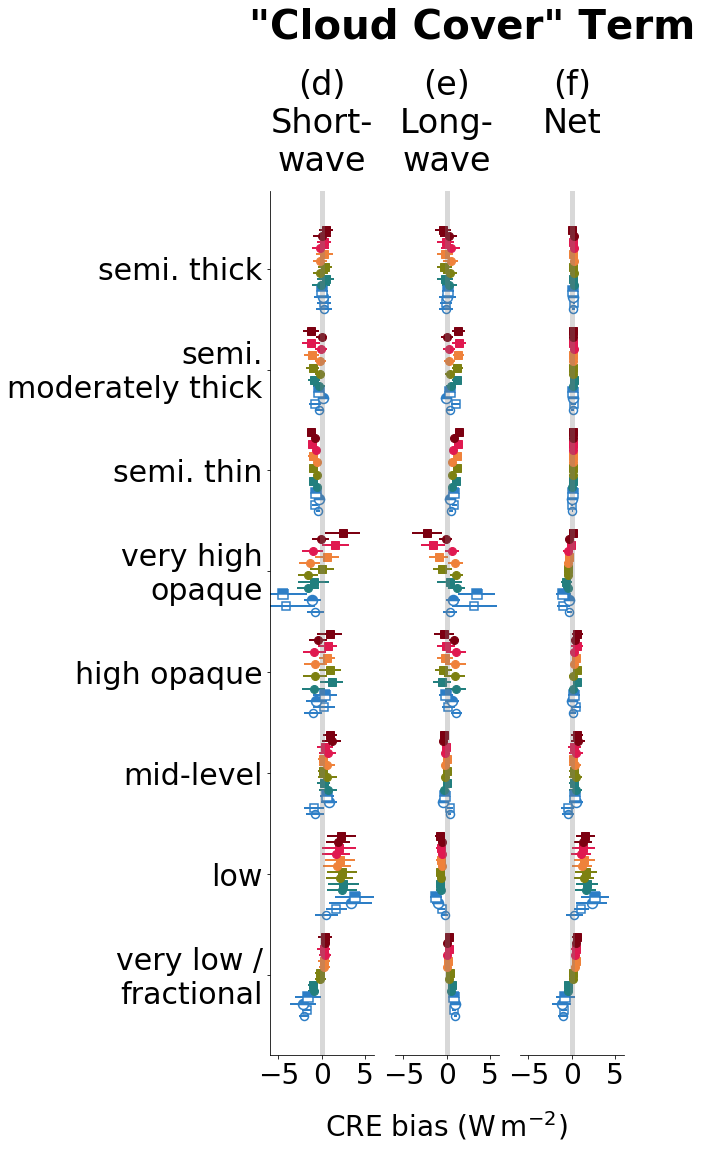

In [181]:
cre_bias_plot( mean_var, var_sem, 'cloud_fraction_term', '"Cloud Cover" Term', iletter = 3, do_legend = False)
pl.savefig( '../pics/cre_bias_cloud_fraction_term-vs-ct.png', dpi = 300,)


### Radiation Flux Term

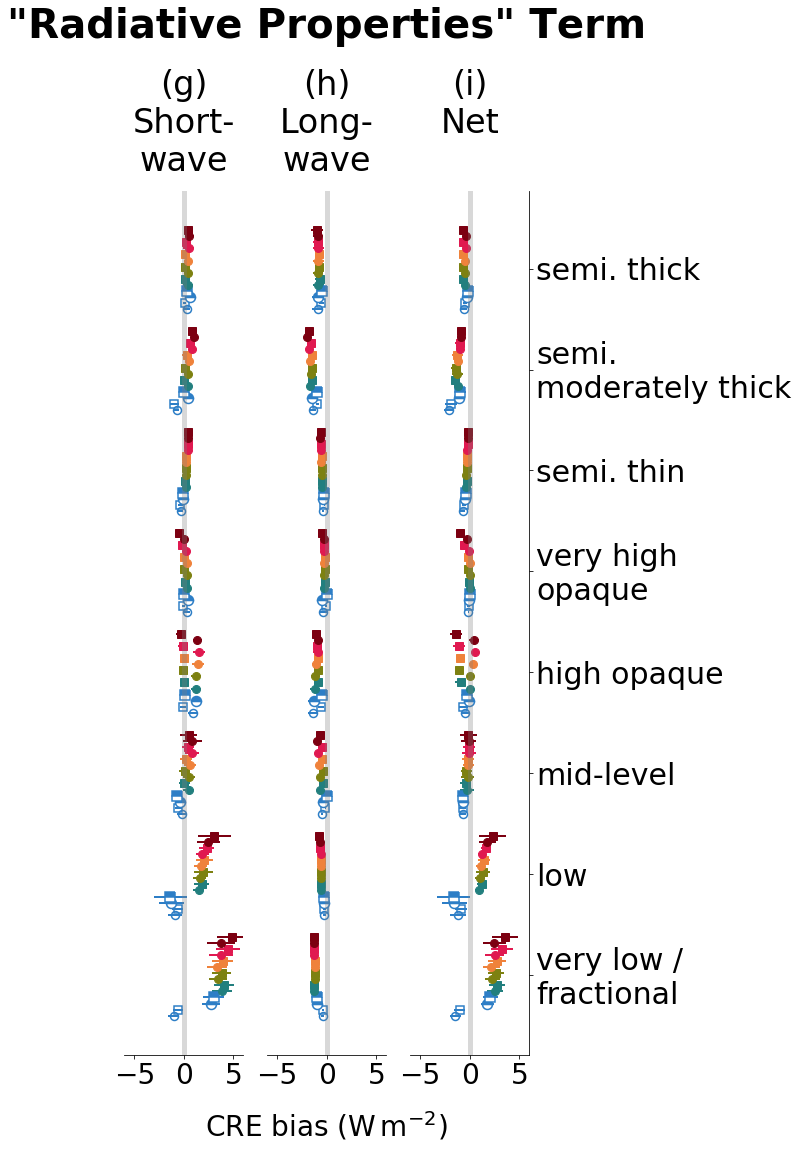

In [182]:
ax = cre_bias_plot( mean_var, var_sem, 'radflux_term', '"Radiative Properties" Term', iletter = 6,  do_legend = False)

sns.despine(left = True, right = False, ax = ax[-1])
sns.despine(left = True, right = True, ax = ax[0])

ax[-1].set_yticks( ax[0].get_yticks() )
ax[0].set_yticks([])

pl.subplots_adjust( left = 0.3, right = 0.7 )
pl.savefig( '../pics/cre_bias_radflux_term-vs-ct.png', dpi = 300,)